# Optimal transportation model applied to healthcare facilities in Covid-19 scenario
## by Giacomo Bacchetta, student ID 1840949
### giacomo.bacchetta4@gmail.com

# 1. Introduction
Analyses of the input Excel file and definition of the useful parameters for the building of the optimal transportation model.

Importing needed Python libraries.

In [1]:
import pandas as pd
import pyomo.environ as pe
import folium as f
import random
from math import *
import matplotlib.pyplot as plt

## 1.1 Infected
Analyses of the InfExp Excel file from which we obtain different lists and series.

In [2]:
InfExp = pd.read_excel('InfExp.xlsx', index_col = 0)
InfExp

prevision
date                 
2021-09-20        498
2021-09-21        483
2021-09-22        481
2021-09-23        477
2021-09-24        473
2021-09-25        464
2021-09-26        460
2021-09-27        452

In [3]:
Dates = InfExp.index[:]
T = Dates.astype(str) 
T = list(T)                                             # list that contains the days of the period T
Prevision = InfExp.loc[Dates,'prevision']               # series about daily infected in Lazio region

Since the values contained in the file are referred to the entire Lazio region, we have to multiply them by both the incidence rate relating to Rome and the italian hospitalization rate.

In [4]:
Incidence_Rate = 0.48 # assumed almost equal to the proportion between inhabitants of Rome and those og the Lazio region
Hospitalization_Rate = 0.038
Prev = Prevision * Incidence_Rate * Hospitalization_Rate  
Prev = Prev.astype(int)     # the series about the daily infected to be hospitalized in the city of Rome
Prev

date
2021-09-20    9
2021-09-21    8
2021-09-22    8
2021-09-23    8
2021-09-24    8
2021-09-25    8
2021-09-26    8
2021-09-27    8
Name: prevision, dtype: int32

## 1.2 Hospitals
Analyses of the Hospitals Excel file.

In [5]:
Hospitals = pd.read_excel('Hospitals.xlsx', index_col=0)
Hospitals

Coordinates Covid
Hospital                                                               
POLICLINICO UMBERTO I       41.90782653426865, 12.510541266988186   Yes
POLICLINICO GEMELLI         41.93210246077846, 12.428657494836862   Yes
POLICLINICO TOR VERGATA    41.858587072830886, 12.630986236281153   Yes
SANT ANDREA                 41.98320988212554, 12.470463782367839    No
OSPEDALE BAMBIN GESU       41.944520734877635, 12.445232901814228   Yes
OSPEDALE SANDRO PERTINI     41.92124073080262, 12.540100651653844    No
OSPEDALE FATEBENEFRATELLI   41.89174868226789, 12.477426389708965   Yes
ISTITUTO SPALLANZANI        41.86717180592309, 12.456050113176275   Yes
POLICLINICO CASILINO        41.86936210887187, 12.590163697269949    No
SAN CAMILLO                  41.87042040958799, 12.45631721236428   Yes

In [6]:
H = Hospitals.index[:]                  # list that contains the names of the hospitals considered.
Coor = Hospitals.loc[H, 'Coordinates']  # series about the position of the hospitals.
Covid = Hospitals.loc[H, 'Covid']       # series that allows us to distinguish Covid hospitals from Non-Covid ones.

Thanks to the Covid series we can define two different lists: H_N contains the non-Covid hospitals, H_C contains the Covid ones. We also define the list of the converted hospitals that is currently empty.

In [7]:
H_N = []
for h ,_ in Covid[Covid == 'No'].items():
    H_N.append(h)
    
H_C = []
for h in H:
    if h not in H_N:
        H_C.append(h)
        
HospitalConverted = [] # this list is empty until the third change

Defining three important information about each hospital: the geographic coordinates (in $\textbf{l}$ dictionary), the ordinary capacity (in $\textbf{c}$ dictionary) and the intensive one (in $\textbf{k}$ dictionary).

In [8]:
l = {}
for h in H:
    pos = Coor[h].split(',')  # separating latitude from longitude
    
    # converting the string in decimal value
    pos_y = float(pos[0])             
    pos_x = float(pos[1])
    
    l[h] = []                     # we insert these decimal values within a list 
                                      # that is the value of each hospital in Pos_h dictionary
    l[h].append(pos_y)
    l[h].append(pos_x)
        
random.seed(3)                        # definiton the seed of the random library


# Since we daily update the capacity (both ordinary and intensive) of the hospitals,
# we define two standard dictionary which will not be updated and modified

oc = {}       
ic = {}
#Since we do not know the real hospital availability we define them by randomly choosing between plausible values
clist = [5,10,20]  
klist = [5,8,10]   
for h in H:
    if h not in H_N:
        oc[h] = random.choice(clist) 
        ic[h] = random.choice(klist)  
    else:
        oc[h] = 0
        ic[h] = 0    

## 1.3 Other parameters

We identify the borders of Rome taking two values of latitude and two of longitude. These will be useful to randomly geolocate the infected.

In [9]:
#longitude
lim_up = 41.990666
lim_down = 41.793519
#latitude
lim_sx = 12.377344
lim_dx = 12.616386

In [10]:
DaySelected = T[-1]  # to implement the code over all the period T
day = T.index(DaySelected)

# 2. Basic Formulation
Building the model of the basic formulation.

$$
\begin{align}
\\
\\
{min} \hspace{18 mm} &\sum_{i\in I} \sum_{h\in H} y_{h,i} \ d_{h,i} \\
s.t.\hspace{18 mm} &\sum_{h\in H} y_{h,i} = 1  \qquad  &\forall \ i \in I \\
&\sum_{i\in I}y_{h,i} \leq c_h  \qquad &\forall \ h\in H \\
\\
\\
&y_{h,i} \in \{0,1\} \qquad &\forall \ h \in H,\forall \ i \in I\\
\\
\\
\end{align}
$$

Since we will update ordinary capacity after each day, we copy the oc dictionary.

In [11]:
c = oc.copy() 

We build the model through Pyomo modeling language.

In [12]:
def create_model(I):
    
    global mdl
    
    mdl = pe.ConcreteModel('Basic formulation')

    mdl.y = pe.Var(H, I, within = pe.Binary) # binary variable to choose which link 'hospital-infected' activate

    mdl.obj_fun = pe.Objective(expr = sum(mdl.y[h, i] * d.at[h, i] for i in I for h in H))

    def all_infected(m, i):
        return sum(m.y[h, i] for h in H) == 1
    mdl.all_infected = pe.Constraint(I, rule = all_infected)  # to guarantee assistance to every infected
    
    def respect_cap(m, h):
        return sum(m.y[h, i] for i in I) <= c[h]
    mdl.respect_cap = pe.Constraint(H, rule = respect_cap) # to respect the total hospital capacity

    solver = pe.SolverFactory('glpk')
    solver.solve(mdl)

The model must be run taking as input the daily number of infected to be hospitalized. At the end of each day we update the hospitals capacities.

In [13]:
p = {}          # dicionary that contains the longitude and latitude value for each infected of the period T
R = 6371        # useful constant for the calculation of the geodetic distances
Sol = {}        # dictionary of the optimal solution that assign one hospital to each infected
InfT = 0        # counter of the number of hospitalization     

for g in range(0,day+1):       
    InfT = InfT + Prev[g]
    
    I = []          # daily infected list
    
    if g != 0:
        for i in range( max(Sol.keys()) + 1, InfT + 1):        
            I.append(i)
            pos_i_x = random.uniform(lim_sx, lim_dx)
            pos_i_y = random.uniform(lim_up, lim_down)
            p[i] = [pos_i_y, pos_i_x]
        
        d = pd.DataFrame(index = H, columns = I)     # matrix of distances between each infected and each hospital
        
        # calculation of geodetic distances to build d matrix
        for h in H: 
            lat_osp = pi * l[h][0] / 180  
            lon_osp = pi * l[h][1] / 180
            for i in I:
                lat_inf = pi * p[i][0] / 180
                lon_inf = pi * p[i][1] / 180
                fi = fabs(lon_osp -lon_inf)  
                q = acos(sin(lat_inf) * sin(lat_osp) + cos(lat_inf) * cos(lat_osp) * cos(fi))
                distance = q * R
                d.at[h, i] = distance
        
        # IMPLEMENTATION OF THE MODEL
        create_model(I) 
        
        for i in I:
            for h in H:
                if mdl.y[h,i]() == 1:
                    Sol[i] = h                  # building the Sol dictionary
                    c[h] = c[h] - 1             # updating hospitals capacities
    else:
        for i in range(1, InfT + 1):
            I.append(i)
            pos_i_x = random.uniform(lim_sx, lim_dx)
            pos_i_y = random.uniform(lim_up, lim_down)
            p[i] = [pos_i_y,pos_i_x]
            
        d = pd.DataFrame(index = H, columns = I)      # matrix of distances between each infected and each hospital 
        
        # calculation of geodetic distances to build d matrix
        for h in H:
            lat_osp = pi * l[h][0] / 180  
            lon_osp = pi * l[h][1] / 180
            for i in I:
                lat_inf = pi * p[i][0] / 180
                lon_inf = pi * p[i][1] / 180
                fi = fabs(lon_osp -lon_inf)  
                q = acos(sin(lat_inf) * sin(lat_osp) + cos(lat_inf) * cos(lat_osp) * cos(fi))
                distance = q * R
                d.at[h, i] = distance 
         
        
        # IMPLEMENTATION OF THE MODEL        
        create_model(I)
        
        for i in I:
            for h in H:
                if mdl.y[h,i]() == 1:
                    Sol[i] = h                  # building the Sol dictionary
                    c[h] = c[h] - 1             # updating hospitalS capacities

Now we define a function that allows us to work quickly with the Folium library and to create a map according to the results obtained from the reference model. \
This function takes as input the dictionary of optimal solutions $\textbf{sol}$ and the boolean values $\textbf{critical}$ (to indicate whether we have treated serious patients) and $\textbf{conversion}$ (to indicate whether we have carried out conversions of non-Covid hospitals).

In [14]:
def draw_map(sol, critical = False, conversion = False):

    m = f.Map(location=[41.9109, 12.4818], zoom_start=11)
    for h in H:
        if Covid[h] == 'Yes':
            title = h
            f.Marker(location = l[h],
                     icon = f.Icon(color = 'green', icon = 'ambulance', prefix = 'fa'),
                     popup = (pos_y, pos_x),
                     tooltip = title).add_to(m)                                 # marker for Covid hospitals
        elif conversion == True and Covid[h] == 'No' and h in HospitalConverted:
            f.Marker(location = l[h],
                     icon = f.Icon(color = 'purple', icon = 'ambulance', prefix = 'fa'),
                     popup = 'Converted',
                     tooltip = h).add_to(m)                                     # marker for converted hospitals
        elif conversion == True and Covid[h] == 'No' and h not in HospitalConverted:
            f.Marker(location = l[h],
                     icon = f.Icon(color = 'beige', icon = 'ambulance', prefix = 'fa'),
                     popup = 'Not Converted',
                     tooltip = h).add_to(m)                                     # marker for non-Covid hospitals
        
        if critical == False and conversion == False:  # for basic formulation and first change
            for i in p.keys():
                pos = p[i]
                title = i
                f.Marker(location = pos, popup = pos, tooltip = title).add_to(m)  # marker for each infected
                if sol[i] == h:
                    h_y = l[h][0]
                    h_x = l[h][1]
                    i_y = pos[0]
                    i_x = pos[1]
                    coordinates = [[h_y, h_x], [i_y, i_x]]
                    f.PolyLine(coordinates, color = 'red', weight = 5).add_to(m)  # link between infected and hospital
        
        elif critical == True and conversion == False or critical == True and conversion == True: #for second and third change
            for i in p.keys():
                pos = p[i]
                title = i
                if i not in S_T:
                    f.Marker(location = pos, popup = pos, tooltip = title).add_to(m) # marker for ordinary infected
                else:
                    f.Marker(location=pos,
                     icon = f.Icon(color = 'red', icon = 'flask', prefix = 'fa'),
                     popup = 'SERIOUS',
                     tooltip = title).add_to(m)  # marker for serious infected

                if sol[i] == h:
                    h_y = l[h][0]
                    h_x = l[h][1]
                    i_y = pos[0]
                    i_x = pos[1]
                    coordinates = [[h_y, h_x], [i_y, i_x]]
                    f.PolyLine(coordinates, color = 'red', weight = 5).add_to(m) # link between infected and hospital

    display(m)
    return

## Results

In [15]:
draw_map(Sol)

Since the dictionary c is modified during the execution of the model and in order not to initialize more parameters, we apply the function clear(), which eliminates every element inside c. The dictionary is then rebuild in the next change through the copy function.

In [16]:
clear(c)

# 3. Changes
Applying of modifications to the model because of the need of a more exhaustive solution or alterations to the reference context.

## 3.1 First change
This change concerns the balancing of hospital's fulfillment.

The model then becomes:\
$$
\begin{align}
\\
\\
{min} \hspace{18 mm} &\sum_{i\in I} \sum_{h\in H} y_{h,i} \ d_{h,i} + w \ z\\
s.t.\hspace{18 mm} &\sum_{h\in H} y_{h,i} = 1  \qquad  &\forall \ i \in I \\
&\sum_{i\in I}y_{h,i} \leq c_h  \qquad  &\forall \ h\in H \\
&\frac{\sum_{i\in I} y_{h,i}}{c_h} \leq z \qquad   &\forall \ h\in H\\
\\
\\
&y_{h,i} \in \{0,1\} \qquad &\forall \ h \in H,\forall \ i \in I\\
&z \in (0,1]
\\
\\
\end{align}
$$

We define at will the value of the constant $\textbf{w}$ which is used to weigh the new term of the objective function containing the decision variable $\textbf{z}$.

In [17]:
w = 100

Since we used the clear() function, let's define the dictionary of ordinary capacities again.

In [18]:
c = oc.copy()

Now we are ready to define the model of the first change with Pyomo library.

In [19]:
def create_model1():
    
    global mdl1
    
    mdl1 = pe.ConcreteModel('First change')

    mdl1.y = pe.Var(H, I, within = pe.Binary)

    def bounds_z(m):
        return (0, 1)
    mdl1.z = pe.Var(bounds = bounds_z, within = pe.NonNegativeReals)    # variable about the maximum percentage of occupation

    mdl1.obj_fun = pe.Objective(expr=sum(mdl1.y[h, i] * d.at[h, i] for i in I for h in H) + w * mdl1.z)
    
    def all_infected(m, i):
        return sum(m.y[h, i] for h in H) == 1
    mdl1.all_infected = pe.Constraint(I, rule = all_infected)
    
    def respect_cap(m, h):
        return sum(m.y[h, i] for i in I) <= c[h]
    mdl1.respect_cap = pe.Constraint(H, rule = respect_cap)

    def percentage_care(m, h):
        return sum(m.y[h, i] for i in I) / c[h] <= mdl1.z
    mdl1.percentage_care = pe.Constraint(H_C, rule = percentage_care)   # balancing hospitals' fullfillment
    
    solver = pe.SolverFactory('glpk')
    solver.solve(mdl1)

Let’s run the model on every day within the T period while we daily update hospital capacities.

In [20]:
Sol1 = {}               # dictionary of optimal solution
InfT = 0                # counter of total infected people over T period

for g in range(0,day+1):      
    InfT = InfT + Prev[g]
    
    I = []              # list of daily infected
    
    if g != 0:
        for i in range(max(Sol1.keys()) + 1, InfT + 1):
                I.append(i)
                
        d = pd.DataFrame(index = H, columns = I)
        for h in H:
            lat_osp = pi * l[h][0] / 180  
            lon_osp = pi * l[h][1] / 180
            for i in I:
                lat_inf = pi * p[i][0] / 180
                lon_inf = pi * p[i][1] / 180
                fi = fabs(lon_osp -lon_inf)  
                q = acos(sin(lat_inf) * sin(lat_osp) + cos(lat_inf) * cos(lat_osp) * cos(fi))
                distance = q * R
                d.at[h, i] = distance
                
        # IMPLEMENTATION OF THE MODEL
        create_model1()            
    
        for i in I:
            for h in H:
                if mdl1.y[h,i]() == 1:
                    Sol1[i] = h        
                    c[h] = c[h] - 1    
    
    else:
        for i in range(1, InfT + 1):
            I.append(i)

        d = pd.DataFrame(index=H, columns=I)
        for h in H:
            lat_osp = pi * l[h][0] / 180  
            lon_osp = pi * l[h][1] / 180
            for i in I:
                lat_inf = pi * p[i][0] / 180
                lon_inf = pi * p[i][1] / 180
                fi = fabs(lon_osp -lon_inf)  
                q = acos(sin(lat_inf) * sin(lat_osp) + cos(lat_inf) * cos(lat_osp) * cos(fi))
                distance = q * R
                d.at[h, i] = distance 
        
        #IMPLEMENTATION OF THE MODEL
        create_model1() 
        
        for i in I:
            for h in H:
                if mdl1.y[h,i]() == 1:
                    Sol1[i] = h      
                    c[h] = c[h] - 1  

### Results

In [21]:
draw_map(Sol1)

In [22]:
clear(c)

## 3.2 Second change
In the second change we consider the presence of serious patients who need specific treatments and an ICU beds. From now on we take into account also the dictionary k of the intensive capacities. 

The mathematical model then becomes:\
$$
\begin{align}
\\
\\
{min} \hspace{18 mm} &\sum_{i\in I} \sum_{h\in H} y_{h,i} \ d_{h,i} + w \ z \\
s.t.\hspace{18 mm} &\sum_{h\in H} y_{h,i} = 1  \qquad &\forall \ i \in I \\
&\sum_{i\in I}y_{h,i} \leq c_h + k_h  \qquad  &\forall \ h \in H \\
&\frac{\sum_{i\in I} y_{h,i}}{c_h + k_h} \leq z \qquad  &\forall \ h\in H\\
&\sum_{i\in S}y_{h,i} \leq k_h \qquad &\forall \ h \in H \\
\\
\\
&y_{h,i} \in \{0,1\} \qquad &\forall \ h \in H,\forall \ i \in I\\
&z \in (0,1]
\\
\\
\end{align}
$$

In [23]:
c = oc.copy()
k = ic.copy()

In [24]:
Intensive_Rate = 0.06   # percentage of serious infected on total daily infected

In [25]:
def create_model2():
    
    global mdl2
    
    mdl2 = pe.ConcreteModel('Second change')

    mdl2.y = pe.Var(H, I, within = pe.Binary)

    def bounds_z(m):
        return (0, 1)
    mdl2.z = pe.Var(bounds = bounds_z, within = pe.NonNegativeReals)

    mdl2.obj_fun = pe.Objective(expr=sum(mdl2.y[h, i] * d.at[h, i] for i in I for h in H) + w * mdl2.z)
    
    def all_infected(m, i):
        return sum(m.y[h, i] for h in H) == 1
    mdl2.all_infected = pe.Constraint(I, rule = all_infected)
    
    def respect_cap(m, h):
        return sum(m.y[h, i] for i in I) <= c[h] + k[h]
    mdl2.respect_cap = pe.Constraint(H, rule = respect_cap)             # respect of total capacity
    
    def percentage_care(m, h):
        return sum(m.y[h, i] for i in I) / (c[h] + k[h]) <= mdl2.z
    mdl2.percentage_care = pe.Constraint(H_C, rule = percentage_care)     # we consider the total capacity as the sum 
                                                                          # of the ordinary one and the intensive one
    def intensive_cap(m, h):
        return sum(m.y[h, i] for i in S) <= k[h]
    mdl2.intensive_cap = pe.Constraint(H, rule = intensive_cap)  # respect of intensive capacity
    
    solver = pe.SolverFactory('glpk')
    solver.solve(mdl2)

In [26]:
Sol2 = {}
InfT = 0
S_T = []         # serious infected of T period

for g in range(0,day+1):        
    InfT = InfT + Prev[g]     # counter of the infected in the period T
    
    I = []          # list of daily ordinary infected
    S = []          # list of daily severe infected
    
    j = 0           # counter of the total severe infected of the period T
    
    if g != 0:
        for i in range(max(Sol2.keys()) + 1, InfT + 1):
            I.append(i)
        
        while j <= int(len(I) * Intensive_Rate):     # filling of daily list S and list S_T
            a = random.choice(I)
            S.append(a)
            j = j + 1
            S_T.append(a)
        
        d = pd.DataFrame(index = H, columns = I)
        for h in H:
            lat_osp = pi * l[h][0] / 180  
            lon_osp = pi * l[h][1] / 180
            for i in I:
                lat_inf = pi * p[i][0] / 180
                lon_inf = pi * p[i][1] / 180
                fi = fabs(lon_osp -lon_inf)  
                q = acos(sin(lat_inf) * sin(lat_osp) + cos(lat_inf) * cos(lat_osp) * cos(fi))
                distance = q * R
                d.at[h, i] = distance 
        
        #IMPLEMENTATION OF THE MODEL
        create_model2()           
    
        for i in I:
            if i not in S:
                for h in H:
                    if mdl2.y[h,i]() == 1:
                        Sol2[i] = h      
                        c[h] = c[h] - 1  
            else:
                for h in H:
                    if mdl2.y[h,i]() == 1:
                        Sol2[i] = h      
                        k[h] = k[h] - 1          # updating the intensive capacity of each hospital
    else:
        for i in range(1, InfT + 1):
            I.append(i)
        
        while j <= int(len(I) * Intensive_Rate):        # filling of daily list S and list S_T         
            a = random.choice(I)
            S.append(a)
            j = j + 1
            S_T.append(a)
        
        d = pd.DataFrame(index=H, columns=I)
        for h in H:
            lat_osp = pi * l[h][0] / 180  
            lon_osp = pi * l[h][1] / 180
            for i in I:
                lat_inf = pi * p[i][0] / 180
                lon_inf = pi * p[i][1] / 180
                fi = fabs(lon_osp -lon_inf)  
                q = acos(sin(lat_inf) * sin(lat_osp) + cos(lat_inf) * cos(lat_osp) * cos(fi))
                distance = q * R
                d.at[h, i] = distance 
        
        #IMPLEMENTATION OF THE MODEL
        create_model2()
        
        for i in I:
            if i not in S:
                for h in H:
                    if mdl2.y[h,i]() == 1:
                        Sol2[i] = h      
                        c[h] = c[h] - 1  
            else:
                for h in H:
                    if mdl2.y[h,i]() == 1:
                        Sol2[i] = h      
                        k[h] = k[h] - 1  # updating the intensive capacity of each hospital

### Results

In [27]:
draw_map(Sol2, critical = True)

Applying the clear function to c and k dictionaries and to the S_T list.

In [28]:
clear(c, k, S_T)

## 3.3 Third change
It deals with the possible conversion of non-COVID hospitals if the number of infected exceeds the total capacity of COVID hospitals available.

The final model therefore is:\
$$
\begin{align}
\\
\\
{min} \hspace{18 mm} &\sum_{i\in I} \sum_{h\in H} y_{h,i} \ d_{h,i} + w \ z + b \sum_{h\in H_{N}}\delta_h  \\
s.t.\hspace{18 mm} &\sum_{h\in H} y_{h,i} = 1  \qquad &\forall \ i \in I \\
&\sum_{i\in I}y_{h,i} \leq c_h + k_h + u \ \delta_h  \qquad  &\forall \ h \in H \\
&\frac{\sum_{i\in I} y_{h,i}}{c_h + k_h} \leq z \qquad  &\forall \ h\in H\\
&\sum_{i\in S}y_{h,i} \leq k_h \qquad &\forall \ h \in H \\
\\
&y_{h,i} \in \{0,1\} \qquad &\forall \ h \in H,\forall \ i \in I\\
&z \in (0,1] \\
&\delta_{h} \in \{0,1\} \qquad &\forall \ h \in H
\\
\\
\end{align}
$$

We define again the c and k dictionaries.

In [29]:
c = oc.copy()
k = ic.copy()

We also estabilish the value of b, the parameter that represents the cost incurred to convert a non-Covid hospital to a Covid one.

In [30]:
b = 20000
u = 20

Building of the model of the third change.

In [31]:
def create_model3(n):
    
    global mdl3
    
    M = 10000

    mdl3 = pe.ConcreteModel('Third change')

    mdl3.y = pe.Var(H, I, within=pe.Binary)
    
    mdl3.delta = pe.Var(H, within=pe.Binary)

    def bounds_z(m):
        return (0, 1)
    mdl3.z = pe.Var(bounds = bounds_z, within = pe.NonNegativeReals)
    
    for h, _ in Covid[Covid == 'Yes'].items():
        mdl3.delta[h].fix(0)

    mdl3.obj_fun = pe.Objective(expr=sum(mdl3.y[h, i] * d.at[h, i] for i in I for h in H) + w * mdl3.z +
                                (sum(mdl3.delta[h] * b for h in H_N)))


    def all_infected(m, i):
        return sum(m.y[h, i] for h in H) == 1
    mdl3.all_infected = pe.Constraint(I, rule = all_infected)
    
    def respect_cap(m, h):
        return sum(m.y[h, i] for i in I) <= c[h] + k[h] + mdl3.delta[h] * u
    mdl3.respect_cap = pe.Constraint(H, rule = respect_cap) # respect of the total capacity considering the possible
                                                            # increase of capacity for non-Covid hospital
    
    def percentage_care(m, h):
        return sum(m.y[h, i] for i in I) / (c[h] + k[h]) <= mdl3.z
    mdl3.percentage_care = pe.Constraint(H_C, rule = percentage_care)
    
    def intensive_cap(m, h):
        return sum(m.y[h, i] for i in S) <= k[h]
    mdl3.intensive_cap = pe.Constraint(H, rule = intensive_cap)

    solver = pe.SolverFactory('glpk')
    solver.solve(mdl3)

In [32]:
Sol3 = {}       
InfT = 0

for g in range(0,day+1):
    InfT = InfT + Prev[g]
    
    I = []   # list of daily ordinary infected
    S = []   # list of daily severe infected
    
    j = 0   
    
    if g != 0 and g!=day:
        for i in range(max(Sol3.keys()) + 1, InfT + 1):
            I.append(i)
        
        while j <= int(len(I) * Intensive_Rate):   
            a = random.choice(I)
            S.append(a)
            j = j + 1
            S_T.append(a)
        
        d = pd.DataFrame(index=H, columns=I) 
        for h in H:
            lat_osp = pi * l[h][0] / 180  
            lon_osp = pi * l[h][1] / 180
            for i in I:
                lat_inf = pi * p[i][0] / 180
                lon_inf = pi * p[i][1] / 180
                fi = fabs(lon_osp -lon_inf)  
                q = acos(sin(lat_inf) * sin(lat_osp) + cos(lat_inf) * cos(lat_osp) * cos(fi))
                distance = q * R
                d.at[h, i] = distance 
                
        #IMPLEMENTATION OF THE MODEL
        create_model3(len(I)) 
        
        for h in H_N:
            if mdl3.delta[h]==1:
                HospitalConverted.append(h)
    
        for i in I:
            if i not in S:
                for h in H:
                    if mdl3.y[h,i]()==1:
                        Sol3[i] = h
                        c[h] = c[h] - 1        
            else:
                for h in H:
                    if mdl3.y[h,i]()==1:
                        Sol3[i] = h
                        k[h] = k[h] - 1        
                        
    elif g!=0 and g == day:     # we suppose that the sudden increase of infected is on the last day of the period T
        
        MaxAddCap = len(H_N) * 20   # maximum addible care beds
        MinIncInf = 0
        MaxIncInf = sum(c.values()) + sum(k.values()) + MaxAddCap # maximum increase of infected to avoid
                                                                                 # that the model does not find a solution
        
        for h in H:
            if Covid[h] == 'Yes':
                MinIncInf = MinIncInf + c[h]
        IncreaseInf = random.randint(MinIncInf, MaxIncInf)
        
        
        Max_Sol3 = max(Sol3.keys())
        for i in range(Max_Sol3 + 1, Max_Sol3 + IncreaseInf + 2):
            I.append(i)
            if i not in list(p.keys()):
                pos_i_x = random.uniform(lim_sx, lim_dx)
                pos_i_y = random.uniform(lim_up, lim_down) 
                p[i] = [pos_i_y,pos_i_x]
        
        while j <= int(len(I) * Intensive_Rate):
            a = random.choice(I)
            S.append(a)
            j = j + 1
            S_T.append(a)
        
        d = pd.DataFrame(index=H, columns=I) 
        for h in H:
            lat_osp = pi * l[h][0] / 180  
            lon_osp = pi * l[h][1] / 180
            for i in I:
                lat_inf = pi * p[i][0] / 180
                lon_inf = pi * p[i][1] / 180
                fi = fabs(lon_osp -lon_inf)  
                q = acos(sin(lat_inf) * sin(lat_osp) + cos(lat_inf) * cos(lat_osp) * cos(fi))
                distance = q * R
                d.at[h, i] = distance
        
        #IMPLEMENTATION OF THE MODEL
        create_model3(len(I))
        
        for h in H_N:
            if mdl3.delta[h]==1:
                HospitalConverted.append(h) # list of the converted hospitals by the model
        
        for i in I:
            if i not in S:
                for h in H:
                    if mdl3.y[h,i]() == 1:
                        Sol3[i] = h
                        c[h] = c[h] - 1      
            else:
                for h in H:
                    if mdl3.y[h,i]() == 1:
                        Sol3[i] = h
                        k[h] = k[h] - 1      
    else:
        #w = 100
        for i in range(1, InfT + 1):
            I.append(i)
        
        
        while j <= int(len(I) * Intensive_Rate):
            a = random.choice(I)
            S.append(a)
            j = j + 1
            S_T.append(a)
        
        d = pd.DataFrame(index=H, columns=I)
        for h in H:
            lat_osp = pi * l[h][0] / 180  
            lon_osp = pi * l[h][1] / 180
            for i in I:
                lat_inf = pi * p[i][0] / 180
                lon_inf = pi * p[i][1] / 180
                fi = fabs(lon_osp -lon_inf)  
                q = acos(sin(lat_inf) * sin(lat_osp) + cos(lat_inf) * cos(lat_osp) * cos(fi))
                distance = q * R
                d.at[h, i] = distance 
                
        #IMPLEMENTATION OF THE MODEL
        create_model3(Prev[0])
        
        for h in H_N:
            if mdl3.delta[h]==1:
                HospitalConverted.append(h) # list of hte converted hospital by the model
        
        for i in I:
            if i not in S:
                for h in H:
                    if mdl3.y[h,i]() == 1:
                        Sol3[i] = h
                        c[h] = c[h] - 1          
            else:
                for h in H:
                    if mdl3.y[h,i]() == 1:
                        Sol3[i] = h
                        k[h] = k[h] - 1          

### Results

In [33]:
draw_map(Sol3, critical = True, conversion = True)

# 4. Comparing the results
Evaluation of the solutions of each model implemented from a quantitative point of view.

In [34]:
clear(c, k)

First of all we define for the last time the dictionaries c and k that in this section will not be modified.

In [35]:
c = oc.copy()
k = ic.copy()

Defining the function that allows us to have an orthogram in which for each hospital is indicated the percentage of the occupied total capacity.

In [36]:
def TableResults(sol, critical = False, conversion = False):
    ValueCap = {}
    for h in H:
        count = 0                 # counter of the infected assisted by each hospital
        for i in sol.keys():
            if sol[i] == h:
                count = count + 1
        if count == 0:
            ValueCap[h] = count
        else:
            if critical == False and conversion == False:
                ValueCap[h] = count / c[h]
            elif critical == True and conversion == False:
                ValueCap[h] = count / (c[h] + k[h])
            elif critical == True and conversion == True:
                ValueCap[h] = count / (c[h] + k[h] + (u * mdl3.delta[h]()))
    BasicGraph = pd.DataFrame(index = ValueCap.keys(), columns = ['Value'])
    BasicGraph.Value = ValueCap.values()
    %matplotlib inline
    BasicGraph.plot(kind = 'bar')
    plt.xlabel('Hospitals')
    plt.ylabel('Percentual assistance')
    plt.show()

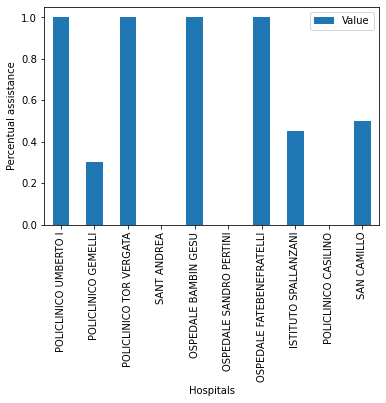

In [37]:
TableResults(Sol) # for the basic formulation

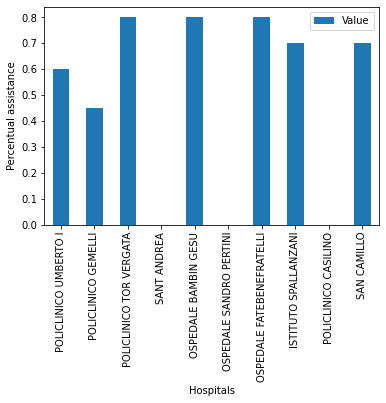

In [38]:
TableResults(Sol1, critical = False) # for the first change

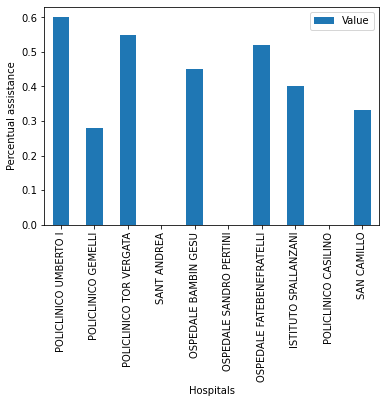

In [39]:
TableResults(Sol2, critical = True) # for the second change

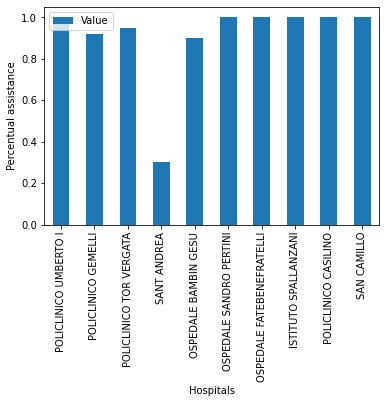

In [40]:
TableResults(Sol3, critical = True, conversion = True) # for the third change